In [21]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
%cd /content/drive/MyDrive/irmapture

/content/drive/MyDrive/irmapture


In [24]:
%cd /content/drive/MyDrive/seg/kaggle_3m

/content/drive/MyDrive/seg/kaggle_3m


In [25]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm

root_dir = '/content/drive/MyDrive/irmapture'
image_size = (128, 128)

images = []
masks = []

for patient_folder in os.listdir(root_dir):
    patient_path = os.path.join(root_dir, patient_folder)

    if not os.path.isdir(patient_path):
        continue

    images_dir = os.path.join(patient_path, "images")
    masks_dir = os.path.join(patient_path, "masks")

    if not os.path.exists(images_dir) or not os.path.exists(masks_dir):
        continue

    for filename in tqdm(os.listdir(images_dir), desc=f"Processing {patient_folder}"):
        if filename.lower().endswith('.png') and '_mask' not in filename.lower():
            image_path = os.path.join(images_dir, filename)

            base_name, _ = os.path.splitext(filename)
            mask_name = base_name + '_mask.png'
            mask_path = os.path.join(masks_dir, mask_name)

            if not os.path.exists(mask_path):
                print(f" No mask for {filename}")
                continue

            try:
                img = Image.open(image_path).convert('L')
                mask = Image.open(mask_path).convert('L')

                img = img.resize(image_size)
                mask = mask.resize(image_size)

                img_array = np.array(img) / 255.0
                mask_array = np.array(mask) / 255.0

                images.append(img_array.reshape(128, 128, 1))
                masks.append(mask_array.reshape(128, 128, 1))
            except Exception as e:
                print(f"Error in {filename}: {e}")

images = np.array(images)
masks = np.array(masks)

print("✅ Images shape:", images.shape)
print("✅ Masks shape:", masks.shape)

Processing patient8: 100%|██████████| 18/18 [00:11<00:00,  1.50it/s]

✅ Images shape: (196, 128, 128, 1)
✅ Masks shape: (196, 128, 128, 1)


In [26]:
import tensorflow as tf

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

In [27]:
from tensorflow.keras.models import load_model

model = load_model("/content/drive/MyDrive/seg/kaggle_3m/unet_model.h5", compile=False)

model.compile(optimizer='adam', loss=dice_loss, metrics=[dice_coef])

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    images, masks, test_size=0.2, random_state=42
)

print("Train shape:", X_train.shape, y_train.shape)
print("Val shape:", X_val.shape, y_val.shape)

Train shape: (156, 128, 128, 1) (156, 128, 128, 1)
Val shape: (40, 128, 128, 1) (40, 128, 128, 1)


In [29]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=8,
    epochs=20,
    verbose=1
)

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 30s 647ms/step - dice_coef: 0.6043 - loss: 0.3959 - val_dice_coef: 0.4119 - val_loss: 0.5881
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 22s 142ms/step - dice_coef: 0.7470 - loss: 0.2530 - val_dice_coef: 0.6882 - val_loss: 0.3118
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - dice_coef: 0.7749 - loss: 0.2253 - val_dice_coef: 0.7393 - val_loss: 0.2607
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - dice_coef: 0.8106 - loss: 0.1894 - val_dice_coef: 0.5901 - val_loss: 0.4099
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step - dice_coef: 0.7909 - loss: 0.2094 - val_dice_coef: 0.7232 - val_loss: 0.2768
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 141ms/step - dice_coef: 0.8360 - loss: 0.1640 - val_dice_coef: 0.7509 - val_loss: 0.2491
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - dice_coef: 0.8329 - loss: 0.1671 - val_dice_coef: 0.7481 - val_loss: 0.2519
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - dice_coef: 0.8332 - loss: 0.1668 -

In [30]:
model.evaluate(X_val, y_val)

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - dice_coef: 0.8434 - loss: 0.1468


[0.15006788074970245, 0.8352478742599487]

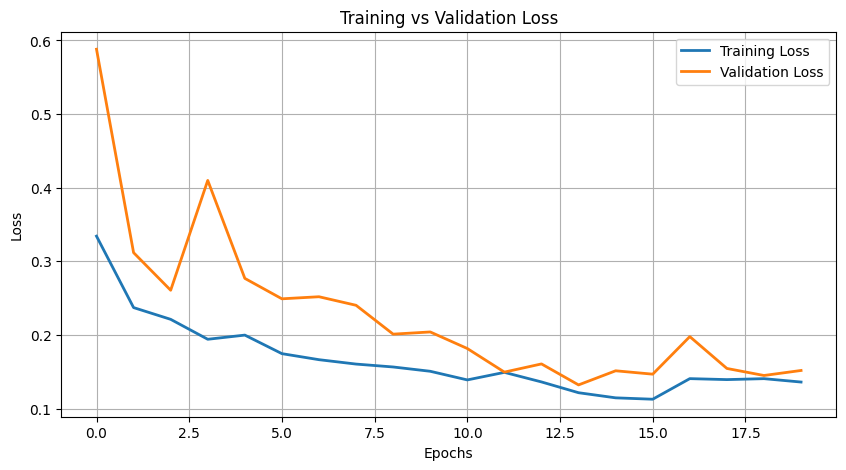

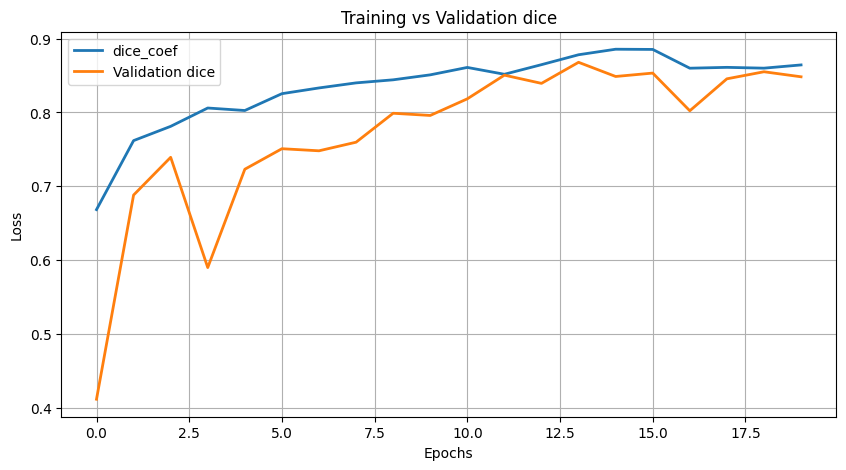

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(history.history['dice_coef'], label='dice_coef', linewidth=2)
plt.plot(history.history['val_dice_coef'], label='Validation dice', linewidth=2)
plt.title("Training vs Validation dice")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


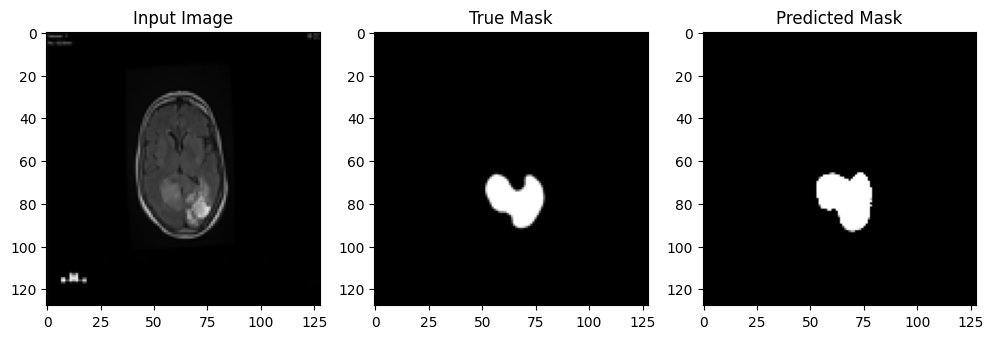

In [33]:
import random
import matplotlib.pyplot as plt
import numpy as np

i = random.randint(0, len(X_val)-1) # Changed X_test to X_val as X_test is not defined
test_img = X_val[i]
test_mask = y_val[i]
pred_mask = model.predict(np.expand_dims(test_img, axis=0))[0]

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Input Image")
plt.imshow(test_img.squeeze(), cmap='gray')

plt.subplot(1, 3, 2)
plt.title("True Mask")
plt.imshow(test_mask.squeeze(), cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(pred_mask.squeeze(), cmap='gray')

plt.show()